In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [24]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # get English words set
    words = set(nltk.corpus.words.words())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations and non_English words
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) & (x in words)]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # cutoff length, tokenized text length < min length will be removed
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

# IMPORT

In [28]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

,Title,Userscore,Comment
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it..."
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...


In [43]:
df.Userscore.value_counts(normalize=True).sort_index()

1.0     0.027710
2.0     0.022842
3.0     0.027145
4.0     0.030296
5.0     0.038518
6.0     0.045787
7.0     0.064979
8.0     0.115427
9.0     0.204131
10.0    0.423166
Name: Userscore, dtype: float64

In [29]:
df.shape

(260269, 3)

In [60]:
df_sub = df.sample(n=5000, random_state=2333)

In [61]:
df_sub.Userscore.value_counts(normalize=True).sort_index()

1.0     0.0284
2.0     0.0194
3.0     0.0264
4.0     0.0300
5.0     0.0372
6.0     0.0456
7.0     0.0696
8.0     0.1168
9.0     0.2030
10.0    0.4236
Name: Userscore, dtype: float64

In [62]:
df.isna().any()

Title        False
Userscore    False
Comment      False
dtype: bool

# Train test split

In [113]:
X = df['Comment']
y = df['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

transformed_tr = X_train.apply(process_text, min_length = 10)
transformed_te = X_test.apply(process_text, min_length = 10)


1m    | 1000 comments<br>
5m43s | 5000 comments

In [66]:
transformed_tr

90236     think best thing ever sanitarium promise drown...
130700    extremely game play extremely smooth basic mod...
63468     love cheat use c move person send person fly a...
129912    easily say best game ever initial technical pa...
240098                                                     
                                ...                        
172175    say best game ever probably put sixty game fac...
120851    game great history graphic fantastic system cl...
225135                                                     
139859    absolutely stun environment early different ex...
56512     best call duty ever make campaign best ever ga...
Name: Comment, Length: 3500, dtype: object

In [15]:
import pickle

# TO EXPORT
transformed_tr.to_pickle('processed_df/transformed_tr_260k.pkl')
transformed_te.to_pickle('processed_df/transformed_te_260k.pkl')

# TO IMPORT
# transformed_tr = pickle.load(open('processed_df/transformed_tr_260k.pkl','rb'))
# transformed_te = pickle.load(open('processed_df/transformed_te_260k.pkl','rb'))

# NB

- baseline

In [71]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('multinb', MultinomialNB())]
NB_pipeline = Pipeline(steps)

In [72]:
NB_pipeline.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [73]:
y_pred = NB_pipeline.predict(transformed_te)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00        24
         3.0       0.00      0.00      0.00        46
         4.0       0.00      0.00      0.00        49
         5.0       0.00      0.00      0.00        48
         6.0       0.00      0.00      0.00        75
         7.0       0.00      0.00      0.00       103
         8.0       0.67      0.02      0.05       169
         9.0       0.18      0.01      0.01       307
        10.0       0.42      1.00      0.59       628

    accuracy                           0.42      1500
   macro avg       0.13      0.10      0.07      1500
weighted avg       0.29      0.42      0.26      1500



c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


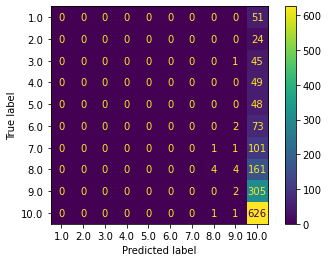

In [75]:
plot_confusion_matrix(NB_pipeline, transformed_te, y_test)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


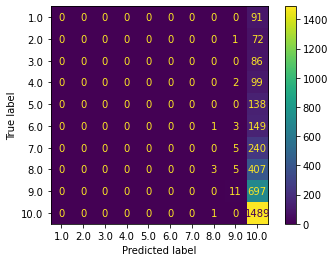

In [83]:
plot_confusion_matrix(NB_pipeline, transformed_tr, y_train)

# Random Forest

- baseline

In [76]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestClassifier())]
rf_pipeline = Pipeline(steps)

In [77]:
rf_pipeline.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('random forest', RandomForestClassifier())])

In [78]:
y_pred = rf_pipeline.predict(transformed_te)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00        24
         3.0       0.00      0.00      0.00        46
         4.0       0.00      0.00      0.00        49
         5.0       0.00      0.00      0.00        48
         6.0       1.00      0.01      0.03        75
         7.0       0.00      0.00      0.00       103
         8.0       0.28      0.09      0.14       169
         9.0       0.22      0.14      0.17       307
        10.0       0.47      0.92      0.62       628

    accuracy                           0.42      1500
   macro avg       0.20      0.12      0.09      1500
weighted avg       0.32      0.42      0.31      1500



c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


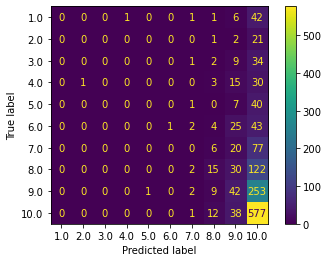

In [80]:
plot_confusion_matrix(rf_pipeline, transformed_te, y_test)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


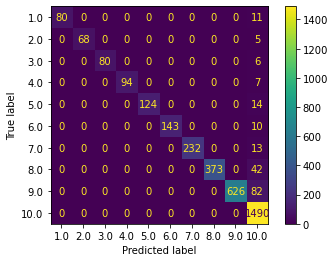

In [81]:
plot_confusion_matrix(rf_pipeline, transformed_tr, y_train)

In [93]:
rf_pipeline[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [82]:
# seems like overfit

- simple man tune

In [106]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestClassifier(max_depth=10))]
rf_pipeline_m = Pipeline(steps)

In [107]:
rf_pipeline_m.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('random forest', RandomForestClassifier(max_depth=10))])

In [108]:
y_pred = rf_pipeline_m.predict(transformed_te)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00        24
         3.0       0.00      0.00      0.00        46
         4.0       0.00      0.00      0.00        49
         5.0       0.00      0.00      0.00        48
         6.0       0.00      0.00      0.00        75
         7.0       0.00      0.00      0.00       103
         8.0       0.50      0.01      0.02       169
         9.0       0.20      0.04      0.07       307
        10.0       0.43      0.99      0.60       628

    accuracy                           0.42      1500
   macro avg       0.11      0.10      0.07      1500
weighted avg       0.28      0.42      0.27      1500



c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


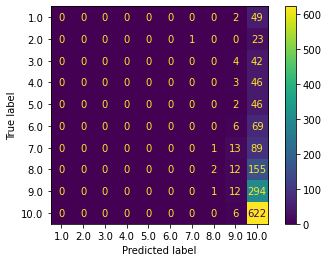

In [110]:
plot_confusion_matrix(rf_pipeline_m, transformed_te, y_test)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


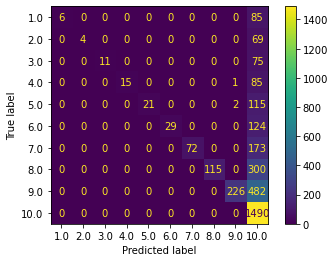

In [111]:
plot_confusion_matrix(rf_pipeline_m, transformed_tr, y_train)

In [112]:
# it's only predicting 10.0????